## **1. 라이브러리 설치 및 가져오기**

In [ ]:
#!pip install ultralytics

In [1]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.129  Python-3.10.16 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Setup complete  (24 CPUs, 31.7 GB RAM, 185.2/953.1 GB disk)


## **2. 데이터셋 가져오기**

## 2-2. 테스트 이미지 나타내기

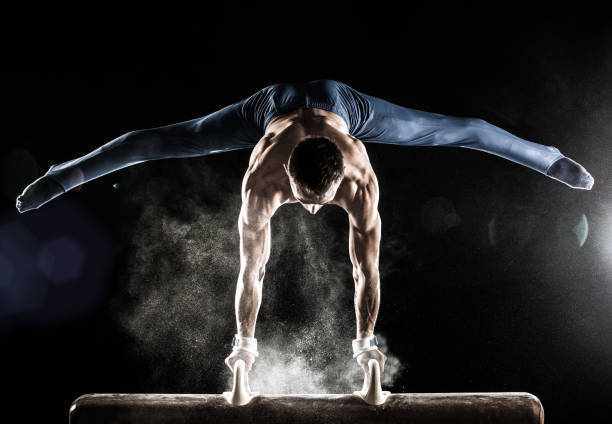

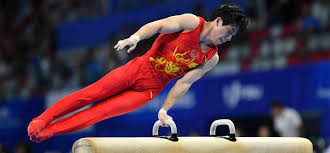

In [2]:
import os
from PIL import Image
# 테스트 이미지 모두 나타내기
# print('test images = ', os.listdir('./test_image_dir'))
image_dir = './test_image_dir'

# 이미지 디렉토리(img_dir)에 있는 파일 중에 .jpg 파일만 불러와 display 하기

for file_name in os.listdir(image_dir):
    file_path = os.path.join(image_dir, file_name)
    # 파일 확장자가 .jpg인 경우에만 처리
    if file_path.endswith('.jpg'):
        with Image.open(file_path) as img:
            display(img)

## **3. 객체 감지하기**(Detection)
### 3-1. 모델 가져오기

In [3]:
# ultralytics 에서 YOLO 가져오기
from ultralytics import YOLO    # ... 코드 입력

# 모델 객체 선언하기 - 'yolov8m-pose' 유형 사용
model = YOLO('yolov8m-pose.pt')     # ... 코드 입력

100%|██████████| 50.8M/50.8M [01:12<00:00, 737kB/s] 


In [4]:
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 1
{0: 'person'}


### 3-2. 예측하기

In [5]:
# test image로 객체 검출하기 - model.predict() 사용, source='./test_image_dir/*.jpg' , save 옵션 - True
results = model.predict(source='./test_image_dir/*.jpg', save=True)    # ... 코드 입력

c:\Users\intel09\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


image 1/2 c:\Users\intel09\Documents\07__CNN_\07__CNN_\04_PoseEstimation\test_image_dir\gym_test1.jpg: 448x640 2 persons, 94.0ms
image 2/2 c:\Users\intel09\Documents\07__CNN_\07__CNN_\04_PoseEstimation\test_image_dir\gym_test2.jpg: 320x640 2 persons, 99.7ms
Speed: 1.3ms preprocess, 96.9ms inference, 29.3ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs\pose\predict


## 3-3.test image 객체 검출 결과 내용 및 이미지 출력
- 테스트 이미지 1개 예측 결과 나타내기


class num : counts = , {0.0: 2}
class num: 0, class name: person      , confidence: 0.72
class num: 0, class name: person      , confidence: 0.37


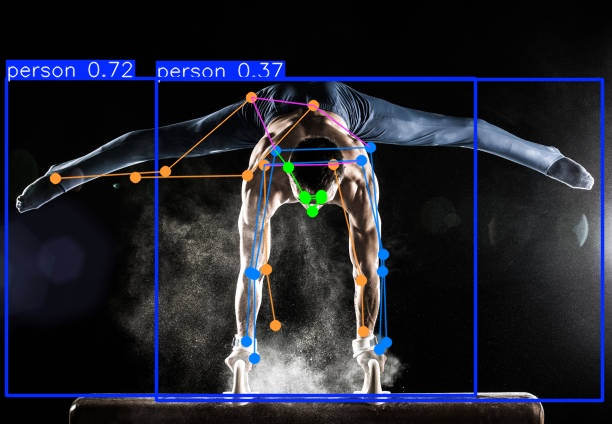

In [6]:
# 방법1
import numpy as np

# 객체의 종류를 나타내는 고유값이 result.boxes.cls에 저장되어 있음 (PyTorch 텐서 형식으로)
# uniq : 고유한 클래스 인덱스 , cnt : 각 클래스의 개수
uniq, cnt = np.unique(results[0].boxes.cls.cpu().numpy(), return_counts=True) # Torch.Tensor => numpy 로 변환
uniq_cnt_dict = dict(zip(uniq, cnt))

# Yolov8모델을 그대로 사용해서 MS COCO Dataset에서 정의한 0~79값이 기본적으로 사용됨
print(f'\nclass num : counts = , {uniq_cnt_dict}')

for i, c in enumerate(results[0].boxes.cls):
    class_id = int(c)
    class_name = results[0].names[class_id]  # 예측 클래스 이름
    confidence_score = results[0].boxes.conf[i]  # 예측 확률
    print(f'class num: {class_id}, class name: {class_name :<12}, confidence: {confidence_score:.2f}')

# 이미지 파일을 엽니다.
with Image.open('./runs/pose/predict/gym_test1.jpg') as pred_image:
    display(pred_image)  # display 함수를 사용해 이미지를 출력합니다.

In [7]:
# 방법2
import numpy as np

# 클래스 ID 및 개수 집계
cls_tensor = results[0].boxes.cls.cpu()
conf_tensor = results[0].boxes.conf.cpu()
uniq, cnt = np.unique(cls_tensor.numpy(), return_counts=True)
uniq_cnt_dict = dict(zip(uniq, cnt))

# 클래스 이름 매핑용
class_names = model.names  # model.names와 동일한 구조

# 클래스별 개수 요약 출력
print('\n[Class Count Summary]')
for cid, count in uniq_cnt_dict.items():
    cname = class_names[int(cid)]
    print(f'Class {cid:2} ({cname:<12}) → {count} object(s)')

# 개별 객체 예측 출력
print('\n[Individual Detections]')
for i, c in enumerate(cls_tensor):
    class_id = int(c)
    class_name = class_names[class_id]
    confidence_score = conf_tensor[i]
    print(f'Class {class_id:2}: {class_name:<12} | Confidence: {confidence_score:.2f}')



[Class Count Summary]
Class 0.0 (person      ) → 2 object(s)

[Individual Detections]
Class  0: person       | Confidence: 0.72
Class  0: person       | Confidence: 0.37


- 테스트 이미지 모두 예측 결과 나타내기

In [8]:
# Yolov8 모델을 사용하여 객체 검출을 수행한 결과를 반복문을 사용하여 다음과 같이 나오도록 출력합니다.
import numpy as np
from pathlib import Path

# model.names 에서 클래스 이름 불러오기
class_names = model.names

# results 에 대한 반복문 추가
for res in results:
    # 1) 클래스 ID 및 개수 집계
    cls_tensor = res.boxes.cls.cpu()
    conf_tensor = res.boxes.conf.cpu()
    uniq, cnt = np.unique(cls_tensor.numpy(), return_counts=True)
    uniq_cnt_dict = dict(zip(uniq, cnt))

    # 이미지 파일 이름 출력
    print(f'\n[Image: {Path(res.path).name}]')

    # 2) 클래스별 개수 요약 출력
    print('[Class Count Summary]')
    for cid, count in uniq_cnt_dict.items():
        cname = class_names[int(cid)]
        print(f'  Class {cid:2} ({cname:<12}) → {count} object(s)')

    # 3) 개별 객체 예측 출력
    print('\n[Individual Detections]')
    for i, c in enumerate(cls_tensor):
        class_id = int(c)
        class_name = class_names[class_id]
        confidence_score = conf_tensor[i]
        print(f'  Class {class_id:2}: {class_name:<12} | Confidence: {confidence_score:.2f}')
     # ... 코드 입력


[Image: gym_test1.jpg]
[Class Count Summary]
  Class 0.0 (person      ) → 2 object(s)

[Individual Detections]
  Class  0: person       | Confidence: 0.72
  Class  0: person       | Confidence: 0.37

[Image: gym_test2.jpg]
[Class Count Summary]
  Class 0.0 (person      ) → 2 object(s)

[Individual Detections]
  Class  0: person       | Confidence: 0.93
  Class  0: person       | Confidence: 0.74


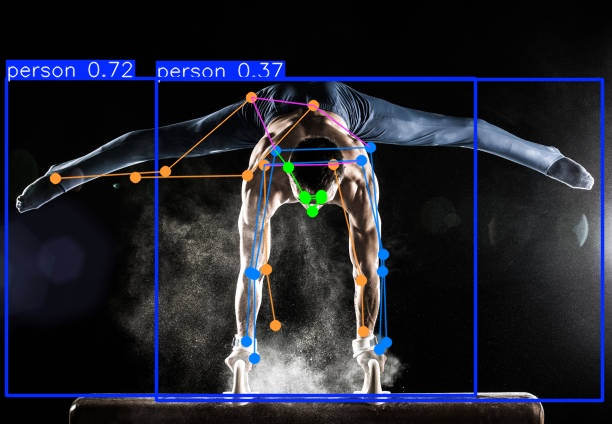

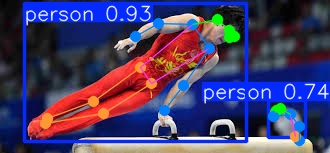

In [9]:
# 테스트 이미지 모두 예측 결과 이미지로 나타내기

# 이미지가 저장된 폴더 경로
image_dir = './runs/pose/predict'

# 폴더 내의 모든 파일을 순회
for file_name in os.listdir(image_dir):
    file_path = os.path.join(image_dir, file_name)
    # 파일 확장자가 .jpg인 경우에만 처리
    if file_path.endswith('.jpg'):
        with Image.open(file_path) as img:
            display(img)